In [369]:
%pip install scikit-learn

  Using cached scikit_learn-1.4.1.post1-cp310-cp310-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached scipy-1.12.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (112 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.3.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.4.1.post1-cp310-cp310-macosx_12_0_arm64.whl (10.4 MB)
Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Using cached scipy-1.12.0-cp310-cp310-macosx_12_0_arm64.whl (31.4 MB)
Using cached threadpoolctl-3.3.0-py3-none-any.whl (17 kB)

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [462]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchview import draw_graph  # attempts to visualize computational graphs
import matplotlib.pyplot as plt
import ffmpeg_quality_metrics as ffqm  # for VMAF calculation
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from PIL import Image
import matplotlib.image as mpimg
import cv2
import os
import random
import subprocess
import json
import numpy as np
import re   # for regular expressions
import csv
from collections import defaultdict
import pandas as pd
import tqdm
import time
import psutil
import pickle

import warnings
warnings.filterwarnings('ignore')

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


black-jack-1990.mp4
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/black-jack-1990.mp4
1798
printing frame number: 375


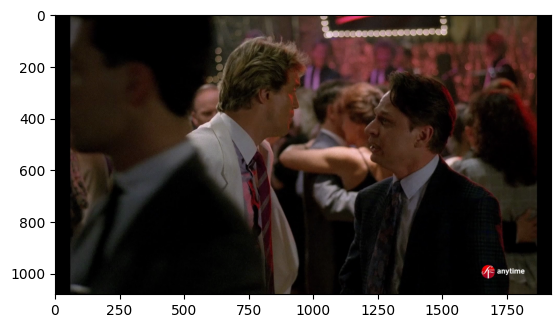

In [102]:
# input video data, training set

train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train"
random_video = random.choice(os.listdir(train))
print(random_video)

video_path = os.path.join(train, random_video)
print(video_path)

cap = cv2.VideoCapture(video_path)

cap_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap_length)

random_frame = random.randrange(0, cap_length)
print("printing frame number:", random_frame)

cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)  # frame 1000

ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  

if ret:
    plt.imshow(frame_rgb)
    plt.show()
    
cap.release()
cv2.destroyAllWindows()


fading-gigolo.mp4
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test/fading-gigolo.mp4
3665
printing frame number: 1606


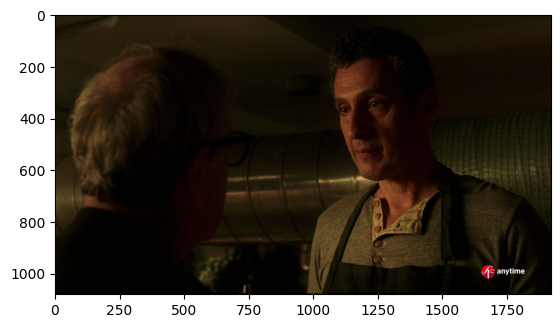

In [25]:
# input video data, test set 

test = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test"
random_video = random.choice(os.listdir(test))
print(random_video)

video_path = os.path.join(test, random_video)
print(video_path)

cap = cv2.VideoCapture(video_path)

cap_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap_length)

random_frame = random.randrange(0, cap_length)
print("printing frame number:", random_frame)

cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)  # frame 1000

ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  

if ret:
    plt.imshow(frame_rgb)
    plt.show()
    
cap.release()
cv2.destroyAllWindows()

In [78]:
# Compression of videos
# compression_levels = [23, 50, 75]
compression_levels = [23, 51]    

for video in os.listdir(train):
    video_path = os.path.join(train, video)
    if not os.path.isfile(video_path):
        continue                   # skip the current iteration if video_path is not a file
    
    # Choose a random compression level
    level = random.choice(compression_levels)
    
    # Construct the compressed file path
    compressed_filename = f"compressed_{level}_{video}"
   
    compressed_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2", compressed_filename)
    
    # Compress the video
    subprocess.run(["ffmpeg", "-i", video_path, "-c:v", "libx264", "-crf", str(level), compressed_path])

    vmaf_command = [
        "ffmpeg",
        "-i", video_path,
        "-i", compressed_path,
        "-lavfi", f"[0:v][1:v]libvmaf=psnr=1:ssim=1:ms_ssim=1:log_fmt=json:log_path=vmaf_log_{level}_{video}.json",
        "-f", "null", "-"
    ]
    subprocess.run(vmaf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

In [9]:
# Compression of test data
# compression_levels = [23, 50, 75]
compression_levels = [23, 51]

for video in os.listdir(test):
    video_path = os.path.join(test, video)
    if not os.path.isfile(video_path):
        continue                    
    
    level = random.choice(compression_levels)
    
    compressed_filename = f"compressed_{level}_{video}"

    compressed_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_TEST_videos", compressed_filename)
    
    # Compress the video
    subprocess.run(["ffmpeg", "-i", video_path, "-c:v", "libx264", "-crf", str(level), compressed_path])

    vmaf_command = [
        "ffmpeg",
        "-i", video_path,
        "-i", compressed_path,
        "-lavfi", f"[0:v][1:v]libvmaf=psnr=1:ssim=1:ms_ssim=1:log_fmt=json:log_path=vmaf_log_{level}_{video}.json",
        "-f", "null", "-"
    ]
    subprocess.run(vmaf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

In [2]:
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train")))    
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2")))

print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test")))    
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_TEST_videos")))


71
70
18
17


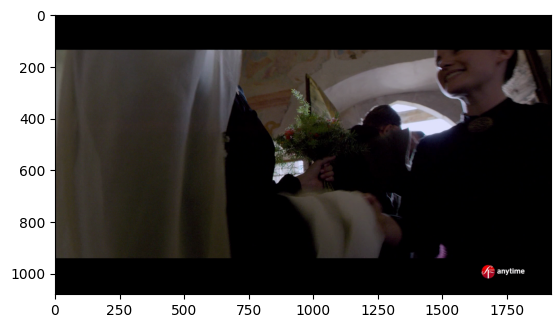

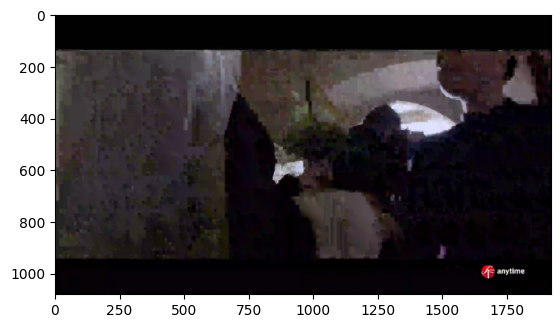

In [3]:
# Display frames with different compression levels
compressed_train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2"

video_path_0 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_0_a-hidden-life.mp4"
video_path_23 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_23_a-hidden-life.mp4"
video_path_50 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_50_a-hidden-life.mp4"
video_path_75 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_75_a-hidden-life.mp4"
    
cap_0 = cv2.VideoCapture(video_path_0)
cap_75 = cv2.VideoCapture(video_path_75)

cap_0.set(cv2.CAP_PROP_POS_FRAMES, 1000)
cap_75.set(cv2.CAP_PROP_POS_FRAMES, 1000)

ret_0, frame_0 = cap_0.read()
frame_rgb_0 = cv2.cvtColor(frame_0, cv2.COLOR_BGR2RGB)   

if ret_0:
    plt.imshow(frame_rgb_0)
    plt.show()
    
    
ret_75, frame_75 = cap_75.read()
frame_rgb_75 = cv2.cvtColor(frame_75, cv2.COLOR_BGR2RGB)   

if ret_75:
    plt.imshow(frame_rgb_75)
    plt.show()
    

im_0 = Image.fromarray(frame_0)
im_75 = Image.fromarray(frame_75)
im_0.save("im0_TEST.png")
im_75.save("im75_TEST.png")

cap_0.release()
cap_75.release()
cv2.destroyAllWindows()

In [103]:
# Contol frame rate in dataset

fps_list = []
for video in os.listdir(train):
    video_path = str(os.path.join(train, video))

    original_cap = cv2.VideoCapture(video_path)
    fps = int(original_cap.get(cv2.CAP_PROP_FPS))
    original_frame_count = int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_list.append(fps)
    
    print(video_path, fps)
    original_cap.release()
    
# print(min(fps_list))
# print(max(fps_list))

/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-svart-fjaril.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/army-of-darkness.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/wallander-forsvunnen.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-player.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/its-a-mad-mad-mad-mad-world.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-mothman-prophecies.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/road-house.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/knife-fight.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-alla-de-stillsamma-doda.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/tiny-tim-king-for-a-day.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/satans-slaves.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/silent-

OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/.DS_Store"


/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/wheel-of-fortune-and-fantasy.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-drommen-forde-dig-vilse.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/bortom-tingri.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/son-of-a-gun.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/rocky-balboa.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/gone-in-60-seconds-1974.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/green-book.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/chitty-chitty-bang-bang.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/les-choses-quon-dit-les-choses-quon-fait.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/delicatessen.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-drommar-ur-sno.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data

In [4]:
# Dataset with frames, ≈ 1 frame / 10 seconds

nr = 1

video_files = sorted(os.listdir(compressed_train))

for video in video_files:
    video_path = os.path.join(compressed_train, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2/train_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()


In [7]:
# Dataset with REFERENCE-frames 

nr = 1

video_files = sorted(os.listdir(train))

for video in video_files:
    video_path = os.path.join(train, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()


OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/.DS_Store"


In [26]:
# dataset with png-images TEST SET

compressed_test = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_TEST_videos"
nr = 1

video_files = sorted(os.listdir(compressed_test))

for video in video_files:
    video_path = os.path.join(compressed_test, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_compressed/TEST_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()

In [27]:
# dataset with REFERENCE-frames TEST SET

nr = 1

video_files = sorted(os.listdir(test))

for video in video_files:
    video_path = os.path.join(test, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST/TEST_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()

OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test/.DS_Store"


/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_359_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2/train_633_compressed_75_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.png


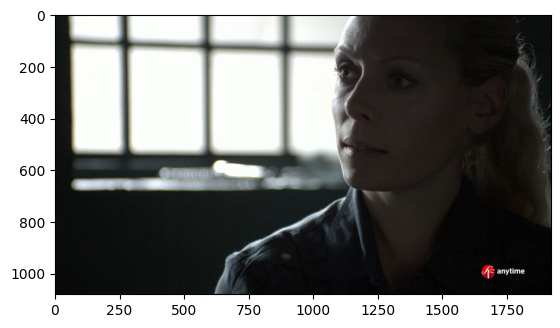

In [3]:
"""
VMAF on cropped frames
Algorithm:
1) Find all uncompressed frame versions. 
2) Crop in a predetermined amount of patches, store in a new folder with descriptive names
3) loop through folder and calculate VMAF, store VMAF values in a new file 
"""
    

In [9]:
# Reference frames CROP, training set

input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png"
crop_size = (224, 224)   # default input size of DenseNet-121

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]         # number of columns
    num_chunks_y = height // crop_size[1]        # number of rows

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   # center of the frame
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)

            """output_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)"""

    im.close()


In [11]:
# compressed frames CROP, training set

input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png"
crop_size = (224, 224)   

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]        
    num_chunks_y = height // crop_size[1]        

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)

            """output_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)"""

    im.close()

In [28]:
# compressed frames CROP, test data

input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_compressed"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png"
crop_size = (224, 224)   

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]        
    num_chunks_y = height // crop_size[1]        

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)


    im.close()


In [29]:
# Reference frames CROP, test data

input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png"
crop_size = (224, 224)   

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]         
    num_chunks_y = height // crop_size[1]        

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)


    im.close()

In [86]:
# Check if lengths are correct

print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png")))
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png")))

print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png")))
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png")))

25952
25952
5920
5920


(1080, 1920, 3)
start row 	-  540
end row 	-  764
start column 	-  540
end column 	-  764
(224, 224, 3)


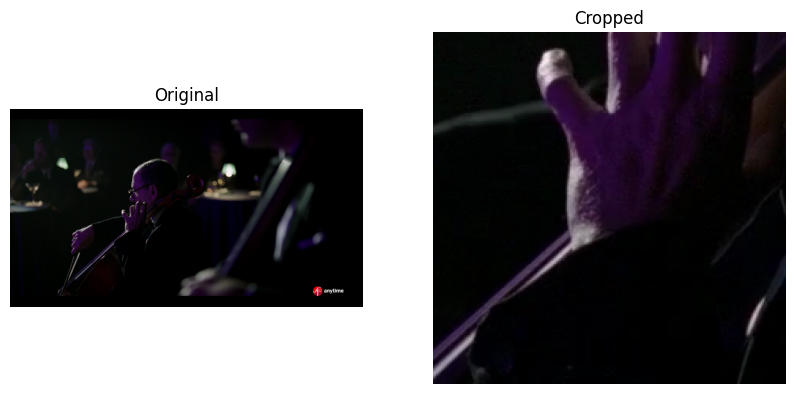

In [131]:
# Center crop test, not used

image_shape = frame_rgb.shape

print(frame_rgb.shape)

length = 224
width = 224

start_row = 540
start_column = start_row

end_row = length + start_row

end_column = width + start_column

print("start row \t- ", start_row)
print("end row \t- ", end_row)
print("start column \t- ", start_column)
print("end column \t- ", end_column)

image_cropped = frame_rgb[start_row:end_row, start_column:end_column]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

ax1.axis("off")
ax1.title.set_text('Original')

ax2.axis("off")
ax2.title.set_text("Cropped")

ax1.imshow(frame_rgb)
ax2.imshow(image_cropped)

print(image_cropped.shape)     # (224, 224, 3)


In [165]:
reference_crops = []
compressed_crops = []

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png", image)
    
    reference_crops.append(im_path)

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png", image)
    
    compressed_crops.append(im_path)

def extract_details_ref(path):
    """
    Extracts movie name, frame number, and crop details from the path.
    """
    components = path.split("_")
    movie_name = components[5]
    frame_number = components[6]
    crop_details = "_".join(components[-2:])
    return movie_name, frame_number, crop_details


def extract_details_comp(path):
    """
    Extracts movie name, frame number, and crop details from the path.
    """
    components = path.split("_")
    movie_name = components[8]
    frame_number = components[9]
    crop_details = "_".join(components[-2:])
    return movie_name, frame_number, crop_details


def sort_by_details_ref(path):
    """
    Sorts by movie name, frame number, and crop details.
    """
    movie_name, frame_number, crop_details = extract_details_ref(path)
    return movie_name, frame_number, crop_details


def sort_by_details_comp(path):
    """
    Sorts by movie name, frame number, and crop details.
    """
    movie_name, frame_number, crop_details = extract_details_comp(path)
    return movie_name, frame_number, crop_details


reference_sorted = sorted(reference_crops, key=sort_by_details_ref)
compressed_sorted = sorted(compressed_crops, key=sort_by_details_comp)

print(reference_sorted[45])
print(compressed_sorted[45])


/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png/train_5_a-hidden-life.mp4_frame1000_right__start_1568_224.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png/train_5_compressed_23_a-hidden-life.mp4_frame1000_right__start_1568_224.png


In [51]:
"""
VMAF terminal command:
ffmpeg-quality-metrics distorted.jpg reference.jpg --metrics vmaf

where ffmpeg - find location of ffmpeg library

Python Subprocess:
From https://www.datacamp.com/tutorial/python-subprocess : 
It's like giving commands to your computer using Python instead of typing them directly into the command prompt. This module makes it easy to automate tasks and integrate other programs with your Python code.
This can be useful for tasks such as log analysis, data processing, and text manipulation.

https://github.com/Netflix/vmaf/issues/1168 : 
When evaluating a single frame, VMAF will set the "motion" feature value to "0", meaning depriving of the motion masking effect from its estimation.

"""

"""def process_image(dist_im, ref_im):
    command = ['/opt/homebrew/bin/ffmpeg', '-i', dist_im, '-i', ref_im, '-lavfi', 'libvmaf', '-f', 'null', '-']
    # command = ['/opt/homebrew/bin/ffmpeg-quality-metrics', dist_im, ref_im, '--metrics', 'vmaf']
    output = subprocess.check_output(command)     # os.system()?
    return output.decode('utf-8')
    # output = os.system(f'ffmpeg-quality-metrics {dist_im} {ref_im} --metrics vmaf')
"""

output_file = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf_values_train.csv" 
if len(reference_sorted) != len(compressed_sorted):
    print("Error: The number of files in the two folders is not the same.")
    exit()

vmaf_scores = []
count = 0
    
for filename1, filename2 in zip(reference_sorted, compressed_sorted):
        image_path_ref = filename1
        image_path_dist = filename2
        
        command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
        output = subprocess.run(command, capture_output=True, text=True)
        
        pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
        match = pattern.search(str(output))
        
        if match:
            vmaf_score = match.group(1)
            vmaf_scores.append([vmaf_score, image_path_dist])
            count +=1
        
        print(count)
            
            
with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['VMAF Score', 'Filename'])
    csv_writer.writerows(vmaf_scores)
       
            
"""print(command)
print("----")

print("matches", match)
print("-----")
print(output)"""
# break

"""if match:
    vmaf_score = match.group(1)
    csv_writer.writerow([vmaf_score])"""
            
# print("VMAF scores written to:", output_file)     

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


'if match:\n    vmaf_score = match.group(1)\n    csv_writer.writerow([vmaf_score])'

/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_466_pojken-med-guldbyxorna.mp4_frame1500.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2/train_141_compressed_23_pojken-med-guldbyxorna.mp4_frame1500.png


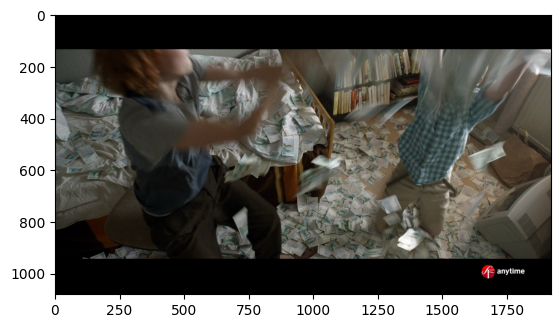

In [137]:
reference_frames = []
compressed_frames = []

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train", image)
    
    reference_frames.append(im_path)

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2", image)
    
    compressed_frames.append(im_path)
        

def sort_by_movie_ref(path):
    return path.split("_")[3]    # film name
   
def sort_by_movie_comp(path):
    return path.split("_")[6]     # film name


def sort_by_frame(path):
    return path.split("_")[-1]       


reference_sorted = sorted(reference_frames, key=sort_by_movie_ref)
compressed_sorted = sorted(compressed_frames, key=sort_by_movie_comp)

reference_sorted_by_frames = sorted(reference_sorted, key=sort_by_frame)
compressed_sorted_by_frames = sorted(compressed_sorted, key=sort_by_frame)


print(reference_sorted_by_frames[250])
print(compressed_sorted_by_frames[250])

plt.imshow(plt.imread(reference_sorted_by_frames[250]))  

In [58]:
# VMAF on full frames, for analysis
output_file2 = "vmaf_on_full_frames_train.csv" 
ref = reference_sorted_by_frames
comp = compressed_sorted_by_frames
if len(ref) != len(comp):
    print("Error: The number of files in the two folders is not the same.")
    exit()

vmaf_scores = []
count = 0
    
for filename1, filename2 in zip(ref, comp):
        image_path_ref = filename1
        image_path_dist = filename2
        
        command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
        output = subprocess.run(command, capture_output=True, text=True)
    
        pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
        match = pattern.search(str(output))
        
        if match:
            vmaf_score = match.group(1)
            vmaf_scores.append([vmaf_score, image_path_dist])
            count +=1
        
        print(count)
            
            
with open(output_file2, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['VMAF Score', 'Filename'])
    csv_writer.writerows(vmaf_scores)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


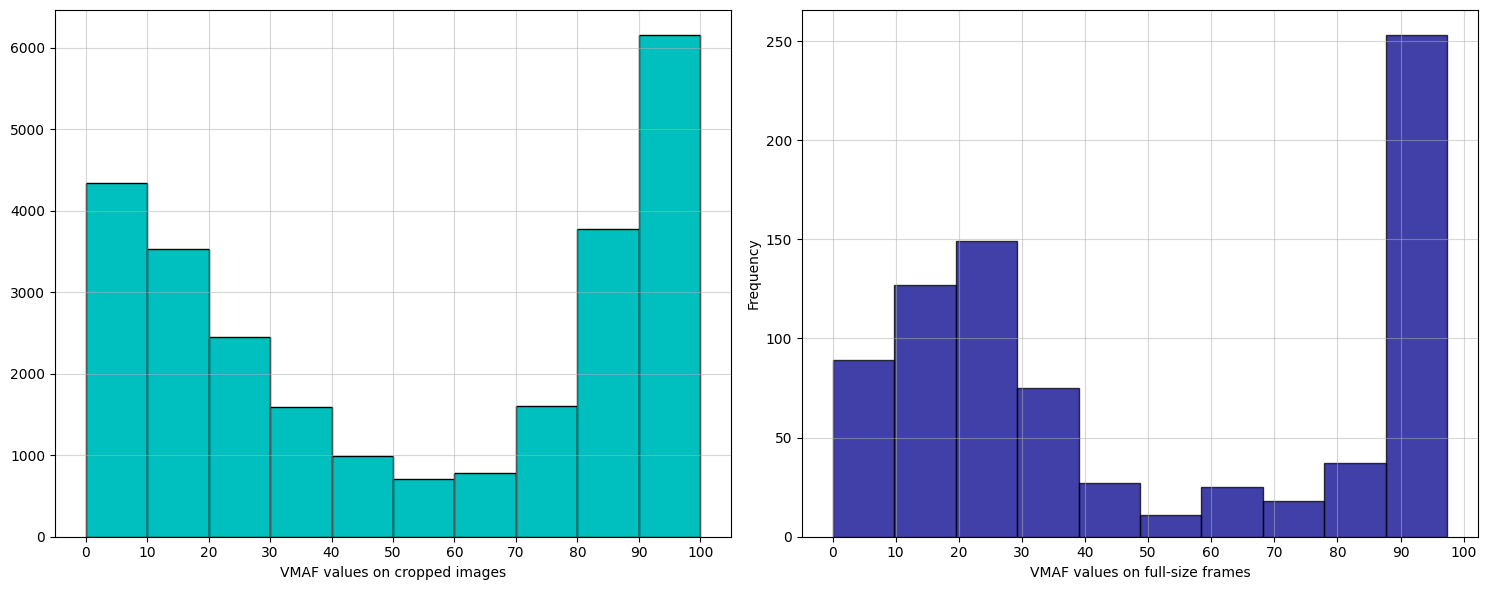

In [86]:
"""
Distribution of VMAF for analysis
"""

file = pd.read_csv("vmaf_values_train.csv")

file2 = pd.read_csv("vmaf_on_full_frames_train.csv")

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(file.iloc[:, 0], edgecolor="k", color="c")
axs[0].grid(alpha=0.5)
axs[0].set_xlabel("VMAF values on cropped images")
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)

axs[1].hist(file2.iloc[:, 0], edgecolor="k", color="darkblue", alpha=0.75)
axs[1].set_xlabel("VMAF values on full-size frames")
axs[1].set_ylabel('Frequency')
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()



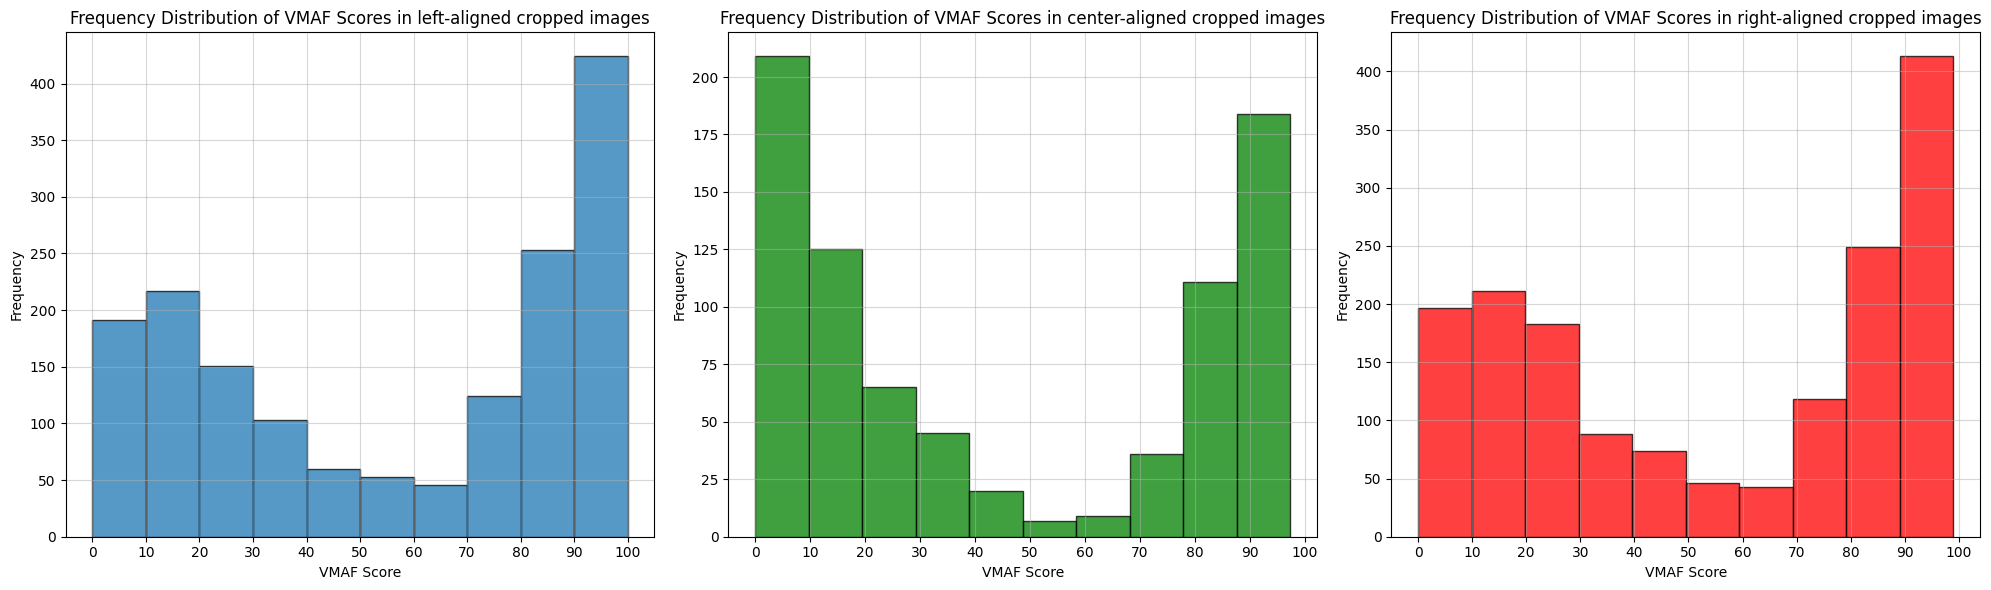

In [109]:
csv_file_path = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf_values_train.csv"

positions = []
left = []
right = []
bottom = []
top = []
center = []
corners = []

with open(csv_file_path, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        vmaf_score = row[0]
        filename = row[1]
        
        position_info = filename.split('/')[-1].split('_')[6:-1]
        position = [vmaf_score, '_'.join(position_info)]
        positions.append(position)
        
        
    for pos in positions:
        if "center" in str(pos[1]):
            center.append(pos)
            
        elif "top" in str(pos[1]):
            top.append(pos)
            
            if "left" or "right" in str(pos[1]):
                corners.append(pos)
            
        elif "bottom" in str(pos[1]):
            bottom.append(pos)
            
            if "left" or "right" in str(pos[1]):
                corners.append(pos)
        
            
        elif "right" in str(pos[1]):
            right.append(pos)
            
        elif "left" in str(pos[1]):
            left.append(pos)
            

vmaf_left = [float(item[0]) for item in left]
vmaf_right = [float(item[0]) for item in right]
vmaf_center = [float(item[0]) for item in center]


fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].hist(sorted(vmaf_left), edgecolor="k", alpha=0.75)
axs[0].set_xlabel('VMAF Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency Distribution of VMAF Scores in left-aligned cropped images')
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)

axs[1].hist(sorted(vmaf_center), edgecolor="k", color="g", alpha=0.75)
axs[1].set_xlabel('VMAF Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency Distribution of VMAF Scores in center-aligned cropped images')
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)

axs[2].hist(sorted(vmaf_right), edgecolor="k", color="r", alpha=0.75)
axs[2].set_xlabel('VMAF Score')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Frequency Distribution of VMAF Scores in right-aligned cropped images')
axs[2].set_xticks(range(0, 101, 10))
axs[2].grid(alpha=0.5)

plt.tight_layout()
plt.show()

        

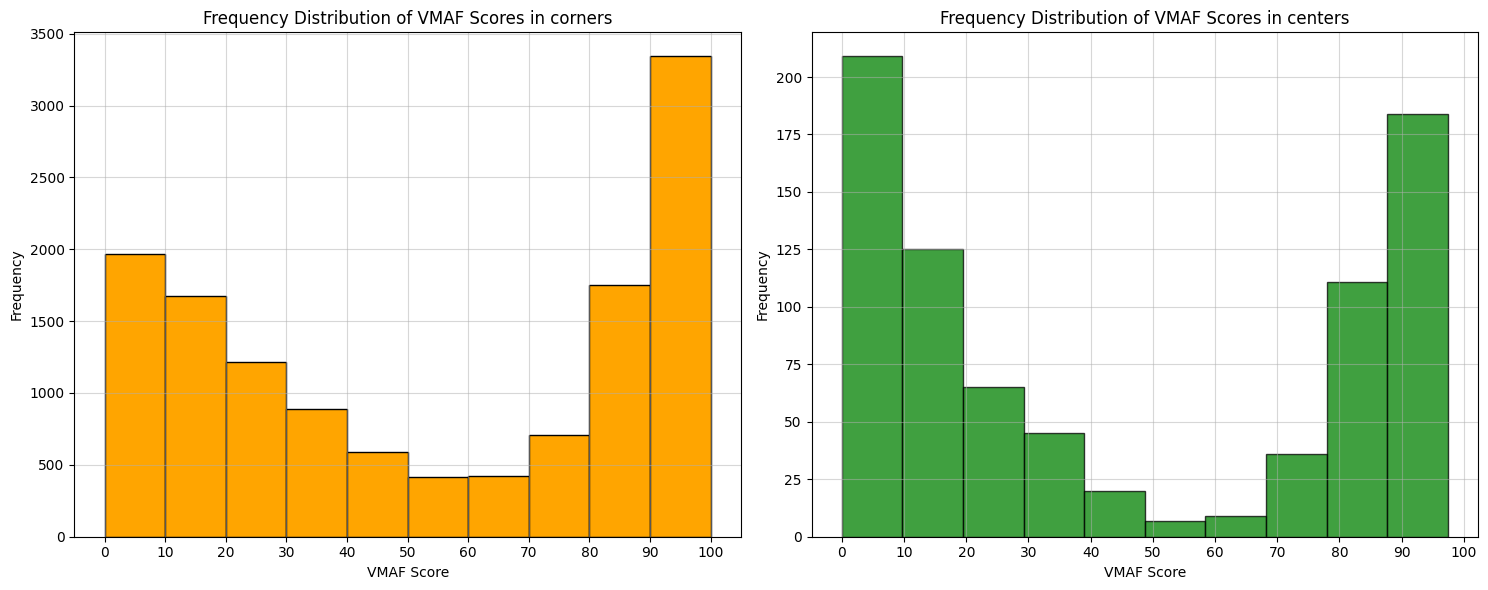

In [110]:
vmaf_corners = [float(item[0]) for item in corners]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(sorted(vmaf_corners), color = "orange", edgecolor="k")
axs[0].set_xlabel('VMAF Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency Distribution of VMAF Scores in corners')    # corners include left bottom, left top, right bottom, right top
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)

axs[1].hist(sorted(vmaf_center), color = "green", edgecolor="k", alpha=0.75)
axs[1].set_xlabel('VMAF Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency Distribution of VMAF Scores in centers')
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()


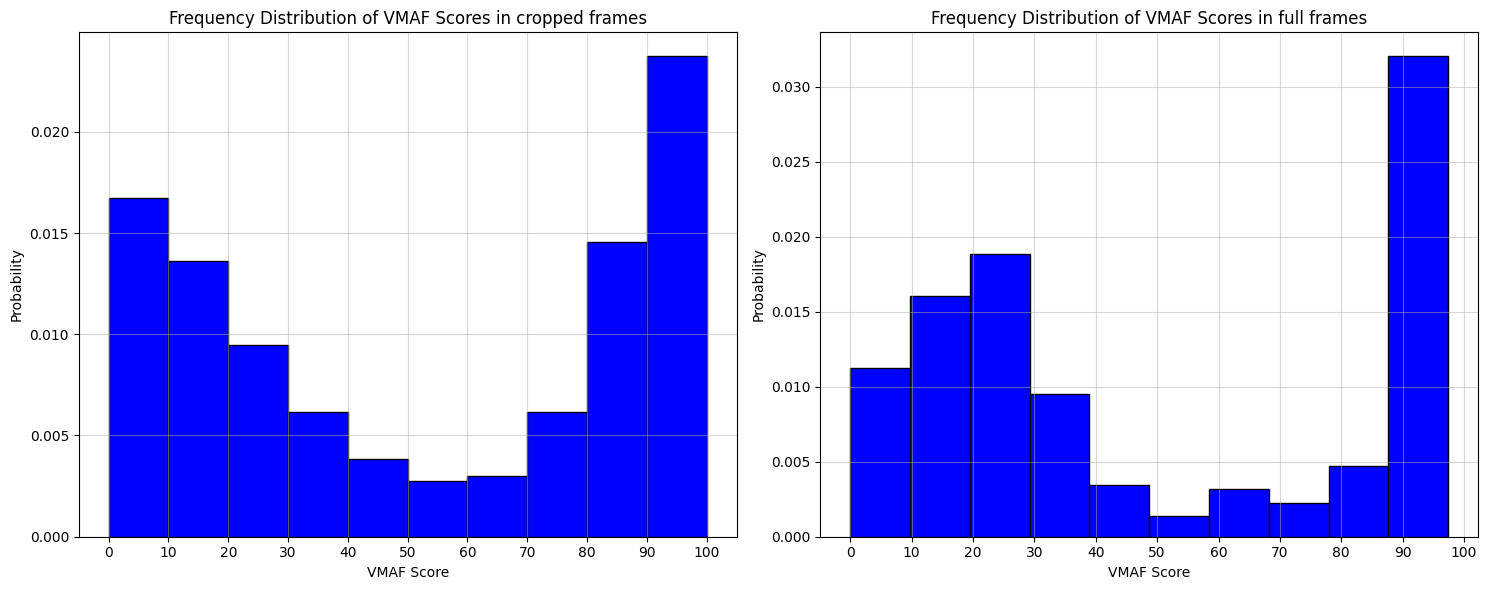

In [131]:
csv_file_path = "vmaf_values_train.csv"
csv_file_path2 = "vmaf_on_full_frames_train.csv"

cropped_scores = []
full_frame_scores = []
with open(csv_file_path, newline='') as csvfile:
    csvfile.readline()
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        vmaf_score = float(row[0])
        cropped_scores.append(vmaf_score)
        
vmaf_scores2 = []
with open(csv_file_path2, newline='') as csvfile:
    csvfile.readline()
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        vmaf_score = float(row[0])
        full_frame_scores.append(vmaf_score)


# print(vmaf_scores)

# full_frame_scores = [float(item[0]) for item in vmaf_scores]
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(sorted(cropped_scores), color = "b", edgecolor="k", density=True)
axs[0].set_xlabel('VMAF Score')
axs[0].set_ylabel('Probability')
axs[0].set_title('Frequency Distribution of VMAF Scores in cropped frames')    
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)

axs[1].hist(sorted(full_frame_scores), color = "b", edgecolor="k", density=True)
axs[1].set_xlabel('VMAF Score')
axs[1].set_ylabel('Probability')
axs[1].set_title('Frequency Distribution of VMAF Scores in full frames')    
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)


plt.tight_layout()
plt.show()


In [56]:
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png")))
df = pd.read_csv('vmaf_values_train.csv')
print(df.shape[0])      

25952
25952


In [172]:
reference_crops_test = []
compressed_crops_test = []

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png", image)
    
    reference_crops_test.append(im_path)

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png", image)
    
    compressed_crops_test.append(im_path)



reference_sorted_test = sorted(reference_crops_test, key=sort_by_details_ref)
compressed_sorted_test = sorted(compressed_crops_test, key=sort_by_details_comp)

print(reference_sorted_test[45])
print(compressed_sorted_test[45])

/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png/TEST_5_agent-cody-banks.mp4_frame1000_right__start_1568_224.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png/TEST_5_compressed_23_agent-cody-banks.mp4_frame1000_right__start_1568_224.png


'print(len(reference_sorted_test))\nprint(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png")))\nprint(len(compressed_sorted_test))\nprint(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png")))'

In [173]:
# VMAF values TEST-set
output_file_test = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf_values_TEST.csv" 
ref = reference_sorted_test
comp = compressed_sorted_test
if len(ref) != len(comp):
    print("Error: The number of files in the two folders is not the same.")
    exit()

vmaf_scores = []
count = 0
    
for filename1, filename2 in zip(ref, comp):
        image_path_ref = filename1
        image_path_dist = filename2
        
        command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
        output = subprocess.run(command, capture_output=True, text=True)
    
        pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
        match = pattern.search(str(output))
        
        if match:
            vmaf_score = match.group(1)
            vmaf_scores.append([vmaf_score, image_path_dist])
            count +=1
        
        print(count)
            
            
with open(output_file_test, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['VMAF Score', 'Filename'])
    csv_writer.writerows(vmaf_scores)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


29.437398
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png/train_599_compressed_75_knives-out.mp4_frame3250_top_start_1344_0.png


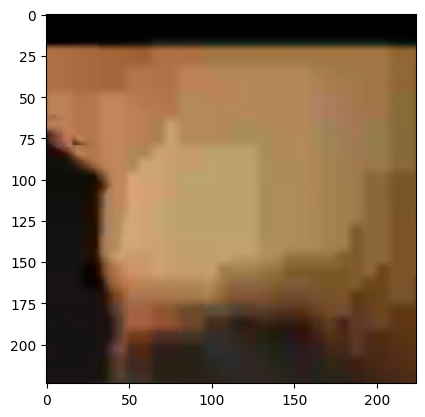

In [148]:
print(pd.read_csv("vmaf_values_train.csv").iloc[9000, 0])
print(os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png", pd.read_csv("vmaf_values_train.csv").iloc[9000, 1]))
plt.imshow(mpimg.imread(os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png", pd.read_csv("vmaf_values_train.csv").iloc[9000, 1])))

In [285]:
# Inspiration from: https://pandas.pydata.org/docs/user_guide/merging.html 

# concat(): Merge multiple Series or DataFrame objects along a shared index or column, inte riktigt rätt. Kanske join="outer"
# merge(): Combine two Series or DataFrame objects with SQL-style joining
# merge_ordered(): Combine two Series or DataFrame objects along an ordered axis
# Series.compare() and DataFrame.compare(): Show differences in values between two Series or DataFrame objects 

class ImagesAndLabelsDataset(Dataset): 
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)      # labels
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getimage__(self, index):
        img_path = self.annotations.iloc[index, 1]
        return img_path
    
    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 1]
        try:
            image = mpimg.imread(img_path)
        except Exception as e:
            print(f"Error reading image at index {index}: {e}")
            return None
        y_label = torch.tensor(self.annotations.iloc[index, 0], dtype=torch.float32)    # VMAF score
        norm = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])   # normalization, from https://pytorch.org/hub/pytorch_vision_densenet/
        
        if self.transform:
            image = self.transform(image)
            norm(image)
        
            
        return (image, y_label, img_path)     # tuple of tensors and img_path
    
    

"""
To train DenseNet on train data:
1) loop over epochs (passes in dataset)
2) loop over minibatches
3) forward pass
4) compute loss
5) backward pass
6) upgrade parameters with optimizer (Adam)

"""
    

'\nTo train DenseNet on train data:\n1) loop over epochs (passes in dataset)\n2) loop over minibatches\n3) forward pass\n4) compute loss\n5) backward pass\n6) upgrade parameters with optimizer (Adam)\n\n'

In [ ]:
data = ImagesAndLabelsDataset(csv_file = "vmaf_values_train.csv", root_dir = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png", transform = transforms.ToTensor())
# Shuffle, with seed for reproducability 
train_set, val_set = torch.utils.data.random_split(data, [0.9, 0.1], generator=torch.Generator().manual_seed(1))    # 10% validation 
train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=100)    # ändra till shuffle = True för träning
val_loader = DataLoader(dataset=val_set, shuffle=True, batch_size=100)

# Data loader combines a dataset and a sampler, and provides an iterable over the given dataset, easy access to the samples

In [500]:
test_data = ImagesAndLabelsDataset(csv_file = "vmaf_values_TEST.csv", root_dir = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png", transform = transforms.ToTensor())
print(test_data.__getimage__(200)) 
test_loader = DataLoader(dataset=test_data, shuffle=False, batch_size=100)
# test_loader = DataLoader(dataset=test_data, shuffle=False, batch_size=100)   # kanske till och med ännu större batch_size för testset?
# pickle-fil
# Fråga om det är bra practise att ha en metod __getimage__, köra att om filnamnet innehåller "center", dela upp i en dataloader, osv.
# måste slice:a testdatan i center, corner, edge etc. Top och bottom också?

/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png/TEST_3_compressed_23_agent-cody-banks.mp4_frame500_top_start_1344_0.png


In [238]:
# validation set? 
# train_data.__len__()
val_set.__len__()         # 2595
# train_set.__len__()     # 23357
# train_data[9000]      # vmaf values as torch.float32

2595

In [246]:
# From https://www.kaggle.com/code/leighplt/densenet121-pytorch
# X_train is the instance with attributes, y_train is the label of each instance
# output layer adjusted for regression instead of classifictaion 
# Single neuron for regression
# loss function: test with MSE and MAE
# efficient=True for efficient run

class DenseNet(nn.Module):
    def __init__(self, num_channels=3):     
        super().__init__()
        preloaded = models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)   # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
        """
        Including a bias term allows the model to learn a better representation of the data by shifting the activation function's output. 
        It effectively adds flexibility to the model's decision boundary, allowing it to fit more complex patterns in the data.
        """
        for param in self.features.parameters():  # Freeze all parameters in self.features
            param.requires_grad = False
           
        """self.dense = nn.Linear(50176, 10000)    # 224 * 224 * 3 = 37632  
        self.dense2 = nn.Linear(10000, 10000)
        self.dense3 = nn.Linear(10000, 1024)"""
        
        # nn.Sequential would have worked too 
        self.dense = nn.Linear(50176, 1024)
        self.dense2 = nn.Linear(1024, 1024)
        self.dense3 = nn.Linear(1024, 1024)
        self.dense4 = nn.Linear(1024, 1024)
        self.dense5 = nn.Linear(1024, 1024)
        self.classifier = nn.Linear(1024, 1)     # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        # self.dense = nn.Linear(802816, 1024)
        
        # unfreeze the dense layers, use these for learning:
        for param in self.dense.parameters():
            param.requires_grad = True
            
        for param in self.dense2.parameters():
            param.requires_grad = True
            
        for param in self.dense3.parameters():
            param.requires_grad = True
            
        for param in self.dense4.parameters(): 
            param.requires_grad = True
            
        for param in self.dense5.parameters(): 
            param.requires_grad = True
        
        for param in self.classifier.parameters():     
            param.requires_grad = True
            
        
    def forward(self, x):
        features = self.features(x)       # hidden layers, feature maps
        out = F.relu(features, inplace=True)     # activation function, A rectified linear unit (ReLU) is an activation function that introduces the property of non-linearity to a deep learning model and solves the vanishing gradients issue.
        out = torch.flatten(out, 1)        # Flattens input by reshaping it into a one-dimensional tensor, from second dimension of input tensor
        out = self.dense(out)   
        out = F.relu(out, inplace=True)
        out = self.dense2(out)
        out = F.relu(out, inplace=True)
        out = self.dense3(out)
        out = F.relu(out, inplace=True)
        out = self.dense4(out)
        out = F.relu(out, inplace=True)
        out = self.dense5(out)
        out = F.relu(out, inplace=True)
        out = self.classifier(out)
        return out.squeeze(1)  # Ensure output is a 1D tensor, reduce array dimensionality, removes axis of length 1
    
    # kanske ta bort squeeze
    
    # Avg pooling smetar ut signalen men är billig


In [272]:
# Train model, from https://www.kaggle.com/code/leighplt/densenet121-pytorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 100    # try some different sizes
model = DenseNet(num_channels=3)

model.to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

# try different learning rates for optimal results
# lr explosion test ?

In [273]:
def evaluate(model, dataloader):
    model.eval()
    losses = []
    with torch.no_grad():
        torch.manual_seed(2)
        for i, data in enumerate(dataloader, 0):     # 0 is start index
            inputs, labels = data
            
            y_pred = model(inputs)   
            
            if i % 10 == 0:         # for quicker runtime
                loss = criterion(y_pred, labels)
                losses.append(loss.item())     # extract only loss, as a PyTorch float
            

    return sum(losses) / len(losses)

In [274]:
train_losses = []
val_losses = []
batch_running_losses = []
num_epochs = 5  

for epoch in range(num_epochs):
    start_epoch_time = time.time()
    model.train()
    running_loss = 0.0     # nollställs för varje epoch
    
    torch.manual_seed(2)        # samma distribution som validation loss
    for i, data in enumerate(train_loader, 0):      # 0 is start index
        if i >= 2500:       # 2500 first data points in the shuffled dataset (around 10%)
            break 
        
        batch_running_loss = 0.0
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  
        
        outputs = model(inputs)     
        
        training_loss = criterion(outputs, labels)
        train_losses.append(training_loss.item()) 
        running_loss += training_loss.item()
        batch_running_loss += training_loss.item()
        
        training_loss.backward()     # backward pass
        
        optimizer.step()             # step
        
        if i % 50 == 0:        # var 50:e (det borde vara så många batches det finns i val). Var 100:onde när vi kör på hela datasetet (ändrade detta, körde 100 först)
            val_loss = evaluate(model, val_loader)
            val_losses.append(val_loss)    
            with open("val.txt", "a") as f2:
                f2.write(str(val_loss))
                f2.write('\n')
                
            model.train()
            
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, batch_running_loss / 25))
            batch_running_losses.append(batch_running_loss / 25)
            batch_running_loss = 0.0
            
            with open("train.txt", "a") as f:
                f.write(str(training_loss.item()))
                f.write('\n')
            
        
        avg_loss_per_epoch = running_loss / len(train_loader)
        """if i % 100 == 0:
            epoch_loss = running_loss / len(train_losses)
            # print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}")
            with open("train.txt", "a") as f:
                f.write(str(running_loss / 100))
                f.write('\n')
            running_loss = 0.0"""
        
    end_epoch_time = time.time()  # End timer for epoch
    epoch_time = end_epoch_time - start_epoch_time
    print(f"Epoch {epoch+1} took {epoch_time} seconds")
    print(f"Avg loss for epoch {epoch+1} is  {avg_loss_per_epoch}")


print("Done!")
    

[1,     1] loss: 134.212
[1,    51] loss: 26.364
[1,   101] loss: 21.639
[1,   151] loss: 18.171
[1,   201] loss: 13.298
Epoch 1 took 3606.405340909958 seconds
Avg loss for epoch 1 is  1082.2653322790422
[2,     1] loss: 27.142
[2,    51] loss: 15.470
[2,   101] loss: 15.849
[2,   151] loss: 13.926
[2,   201] loss: 9.836
Epoch 2 took 3717.9816648960114 seconds
Avg loss for epoch 2 is  368.0784638559716
[3,     1] loss: 21.701
[3,    51] loss: 13.847
[3,   101] loss: 14.304
[3,   151] loss: 16.368
[3,   201] loss: 9.218
Epoch 3 took 3967.7539801597595 seconds
Avg loss for epoch 3 is  312.712038154276
[4,     1] loss: 18.231
[4,    51] loss: 12.839
[4,   101] loss: 10.202
[4,   151] loss: 11.183
[4,   201] loss: 8.172
Epoch 4 took 3556.4288442134857 seconds
Avg loss for epoch 4 is  290.5491834787222
[5,     1] loss: 19.766
[5,    51] loss: 16.007
[5,   101] loss: 9.864
[5,   151] loss: 10.685
[5,   201] loss: 7.973
Epoch 5 took 3471.64413022995 seconds
Avg loss for epoch 5 is  289.401440

'while True:\n    cpu_percent = psutil.cpu_percent(interval=1)\n    print(f"CPU Usage: {cpu_percent}%")\n    disk_usage = psutil.disk_usage(\'/\')\n    print(f"Disk Usage: {disk_usage.percent}%")\n    time.sleep(1)'

In [ ]:
"""new_model_instance = DenseNet(num_channels=3)

new_model_instance.to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  """

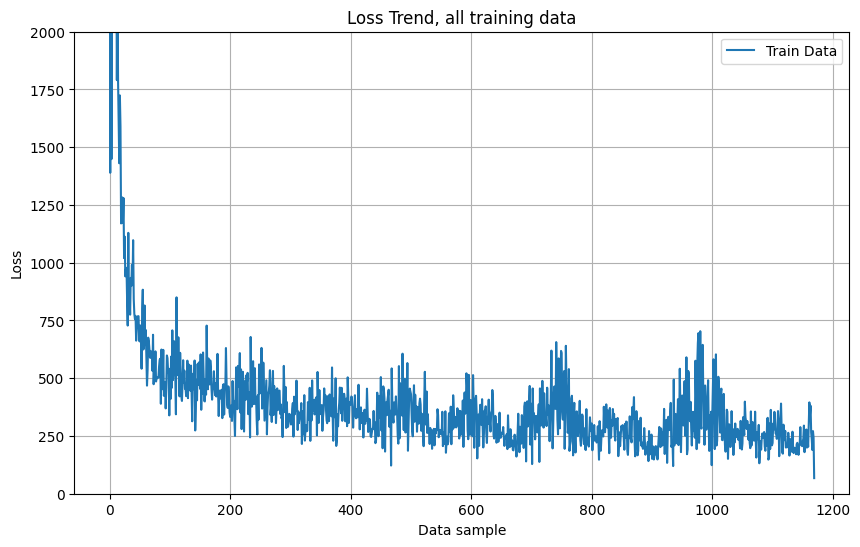

In [282]:
window_size = 10
moving_avg = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
indices = np.arange(window_size//2, len(train_losses) - window_size//2 + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Data')
# plt.plot(indices, moving_avg, color='red', label=f'Moving Average (Window Size = {window_size})')
plt.xlabel('Data sample')
plt.ylabel('Loss')
plt.title('Loss Trend with Moving Average, LR=0.001')

plt.xlabel('Data sample')
plt.ylabel('Loss')
plt.ylim(0, 2000)
plt.title('Loss Trend, all training data')
plt.legend()
plt.grid(True)
plt.show()

1170
25


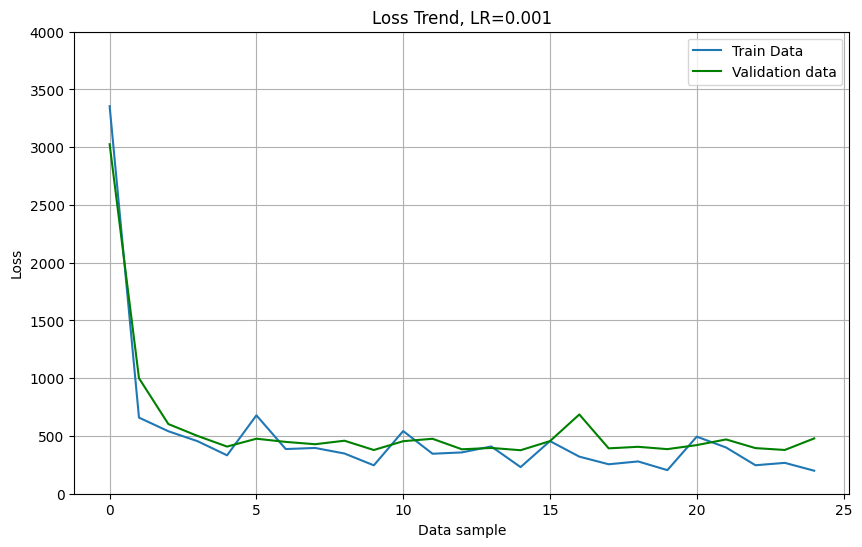

In [278]:
# Loss trend plots

losses = []
validation = []
with open ("train.txt", 'r') as f:
    for line in f: 
        losses.append(float(line))
        

with open("val.txt", "r") as f2:
    for line2 in f2:
        validation.append(float(line2))
        

print(len(train_losses))
print(len(val_losses))
window_size = 10
# Calculate the moving average using np.convolve
moving_avg = np.convolve(losses[0:50], np.ones(window_size)/window_size, mode='valid')

# Calculate the indices for plotting
indices = np.arange(window_size//2, len(losses) - window_size//2 + 1)
# print(len(indices))

# Plot the original data and the smoothed data
plt.figure(figsize=(10, 6))
# plt.plot(training_loss, label='Original Data')
plt.plot(losses, label='Train Data')
# plt.plot(indices, moving_avg, color='red', label=f'Moving Average (Window Size = {window_size})')
plt.plot(validation, label= "Validation data", color="g")
# plt.xticks(range(0, 50, 5))
# plt.yticks(range(0, 12500, 1000))
plt.xlabel('Data sample')
plt.ylabel('Loss')
plt.ylim(0, 4000)
plt.title('Loss Trend, LR=0.001')
plt.legend()
plt.grid(True)
plt.show()
        

In [501]:
def test_model(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    image_paths = []
    with torch.no_grad():
        for data in dataloader:              
            inputs, labels, img_paths = data      # inputs are tensorized images
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy()) 
            true_labels.extend(labels.cpu().numpy())
            image_paths.extend(img_paths)

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    image_paths = np.array(image_paths)

    return predictions, true_labels, image_paths

In [502]:
predictions, true_labels, image_paths = test_model(model, test_loader)
test_df = pd.DataFrame({'Image_Path': image_paths, 'Ground_Truth': true_labels, 'Inference': predictions}) # plocka ut bara komp_nivå, film och crop

In [503]:
centers = test_df[test_df["Image_Path"].str.contains("center")]
corners = test_df[(test_df["Image_Path"].str.contains("bottom") | test_df["Image_Path"].str.contains("top")) & (test_df["Image_Path"].str.contains("left") | test_df["Image_Path"].str.contains("right"))]
edges = test_df[(test_df["Image_Path"].str.contains("bottom") | test_df["Image_Path"].str.contains("top") | test_df["Image_Path"].str.contains("right") | test_df["Image_Path"].str.contains("left"))] 

test_df['Position'] = 'Other'   # alla positioner som inte tillhör kategorierna ovan
test_df.loc[test_df.index.isin(edges.index), 'Position'] = 'Edge'
test_df.loc[test_df.index.isin(corners.index), 'Position'] = 'Corner'
test_df.loc[test_df.index.isin(centers.index), 'Position'] = 'Center'

test_df['Compression_Level'] = test_df['Image_Path'].apply(lambda x: x.split('_')[7].split('_frame')[0])
test_df['Movie_Name'] = test_df['Image_Path'].apply(lambda x: x.split('_')[8].split('_frame')[0])

print(test_df)

test_df.to_csv('inference.csv', index=False)
# result = test_df[test_df['Position'] == "Edge"]
# print(result)

                                             Image_Path  Ground_Truth  \
0     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
1     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
2     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
3     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
4     /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     97.427361   
...                                                 ...           ...   
5915  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     15.288772   
5916  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     33.728546   
5917  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      8.276562   
5918  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...      8.895346   
5919  /Users/kajsalidin/Desktop/nr-vqa-vmaf/images_T...     24.329754   

      Inference Position Compression_Level                  Movie_Name  
0     99.955971   Corner                23        

In [463]:
test_df.to_pickle("inference.pkl")       # pickle file

In [456]:
csv_file_path = "inference.csv"
csv_file_path2 = "vmaf_values_TEST.csv"
vmaf_from_inference= []
vmaf_from_gt = []

with open(csv_file_path, newline='') as csvfile:
    csvfile.readline()
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        vmaf_score = float(row[1])
        vmaf_from_inference.append(vmaf_score)
        
vmaf_scores2 = []
with open(csv_file_path2, newline='') as csvfile:
    csvfile.readline()
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        vmaf_score = float(row[0])
        vmaf_from_gt.append(vmaf_score)
        
print(vmaf_from_inference[0])      
print(vmaf_from_gt[0])

print(vmaf_from_inference[1])      
print(vmaf_from_gt[1])

print(vmaf_from_inference[100])      
print(vmaf_from_gt[100])

print(vmaf_from_inference[1200])      
print(vmaf_from_gt[1200])

print(vmaf_from_inference[5000])      
print(vmaf_from_gt[5000])

26.181093
97.427361
28.879814
97.427361
92.36222
71.35604
84.86551
84.191232
67.59142
32.908323


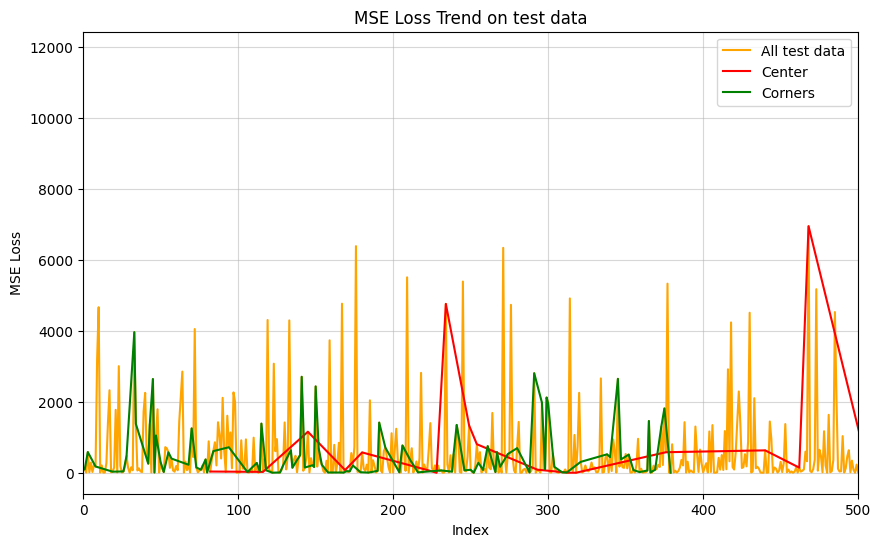

In [461]:
df = pd.read_csv("inference.csv")
ground_truths = df["Ground_Truth"]
predictions = df["Inference"]

mse_values = []
for true, pred in zip(ground_truths, predictions):
    mse = mean_squared_error([true], [pred])  
    mse_values.append(mse)

# print(mse_values)

# print(len(mse_values))

df['MSE'] = mse_values

center_df = df[df["Image_Path"].str.contains("center")]
left_df = df[df["Image_Path"].str.contains("left")]
right_df = df[df["Image_Path"].str.contains("right")]
top_df = df[df["Image_Path"].str.contains("top")]
bottom_df = df[df["Image_Path"].str.contains("bottom")]
corner_df = df[(df["Image_Path"].str.contains("bottom") | df["Image_Path"].str.contains("top")) & (df["Image_Path"].str.contains("left") | df["Image_Path"].str.contains("right"))]

# print(center_df.shape[0])
# print(bottom_df.shape[0])
# print(corner_df.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(df['MSE'], color="orange", label="All test data")
plt.plot(center_df['MSE'], color="r", label="Center")
# plt.plot(left_df['MSE'][0:100], color="b", label="Left edge")
plt.plot(corner_df['MSE'][0:100], color='g', label="Corners")
plt.xlim(0, 500)
# plt.ylim(-50, 8000)
"""plt.plot(center_df['MSE'][0:100], color="r", label="Center")
plt.plot(left_df['MSE'][0:100], color="b", label="Left edge")
plt.plot(right_df['MSE'][0:100], color="g", label="Right edge")
plt.plot(top_df['MSE'][0:100], color="c", label="Upper edge")
plt.plot(bottom_df['MSE'][0:100], color="m", label="Lower edge")"""
plt.xlabel('Index')
plt.ylabel('MSE Loss')
plt.title('MSE Loss Trend on test data')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [459]:
r_squared_values = []
ground_truths = df["Ground_Truth"]
predictions = df["Inference"]

r_squared = r2_score(ground_truths, predictions)

print("R-squared score on the entire test set:", r_squared)
print("R-squared score on center crops:", r2_score(center_df["Ground_Truth"], center_df["Inference"]))
print("R-squared score on corner crops:", r2_score(corner_df["Ground_Truth"], corner_df["Inference"]))

std_dev = np.std(ground_truths - predictions)
print("Standard deviation of the entire test set", std_dev)

print("Standard deviation of center crops", np.std(center_df["Ground_Truth"] - center_df["Inference"]))
print("Standard deviation of corner crops", np.std(corner_df["Ground_Truth"] - corner_df["Inference"]))
print("Standard deviation of upper edge crops", np.std(top_df["Ground_Truth"] - top_df["Inference"]))
print("Standard deviation of lower edge crops", np.std(bottom_df["Ground_Truth"] - bottom_df["Inference"]))
    
# plt.figure(figsize=(10, 6))
# plt.plot(df['R-squared'], color="orange", label="All test data")

R-squared score on the entire test set: 0.4794912797463763
R-squared score on center crops: 0.4708255408918284
R-squared score on corner crops: 0.48195583161860034
Standard deviation of the entire test set 23.70193410486306
Standard deviation of center crops 25.880984864362567
Standard deviation of corner crops 22.654731117164197
Standard deviation of upper edge crops 23.70193410486306
Standard deviation of lower edge crops 23.996119279998187


In [86]:
# New model instance with absolute error loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16    
model2 = DenseNet(num_channels=3)

model2.to(device)

criterion = nn.L1Loss()   # MAE loss 
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)  

In [87]:
model2.train()     # model.train() tells your model that you are training the model
num_epochs = 5   
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        if i >= 2500:
            break
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        
        outputs = model2(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:   
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        

print('Done')

[1,   100] loss: 48.413
[1,   200] loss: 46.208
[1,   300] loss: 36.234
[1,   400] loss: 39.384
[1,   500] loss: 35.849
[1,   600] loss: 40.825
[1,   700] loss: 35.134
[1,   800] loss: 27.425
[1,   900] loss: 30.296
[1,  1000] loss: 27.604
[1,  1100] loss: 28.569
[1,  1200] loss: 28.903
[1,  1300] loss: 28.523
[1,  1400] loss: 30.390
[1,  1500] loss: 35.039
[1,  1600] loss: 31.205
[1,  1700] loss: 27.541
[1,  1800] loss: 29.534
[1,  1900] loss: 27.700
[1,  2000] loss: 30.636
[1,  2100] loss: 26.934
[1,  2200] loss: 27.080
[1,  2300] loss: 28.041
[1,  2400] loss: 29.321
[1,  2500] loss: 26.656
[2,   100] loss: 24.872
[2,   200] loss: 25.433
[2,   300] loss: 26.715
[2,   400] loss: 28.643
[2,   500] loss: 24.837
[2,   600] loss: 24.538
[2,   700] loss: 25.515
[2,   800] loss: 21.512
[2,   900] loss: 21.691
[2,  1000] loss: 23.802
[2,  1100] loss: 20.815
[2,  1200] loss: 23.275
[2,  1300] loss: 24.492
[2,  1400] loss: 21.512
[2,  1500] loss: 21.344
[2,  1600] loss: 21.945
[2,  1700] loss:

In [88]:
model2.eval()

for epoch in range(num_epochs):
    for j, batch in enumerate(val_loader, 0):
        inputs, labels = batch

        inputs = inputs.to(device)
        labels = labels.to(device)

        y_pred = model2(inputs)
        loss = criterion(y_pred, labels)
        
        running_loss2 += loss.item()
        
        if j % 25 == 24:    
            print('[%d, %5d] loss: %.3f' % (epoch + 1, j + 1, running_loss2 / 100))
            running_loss2 = 0.0

[1,    25] loss: 508.523
[1,    50] loss: 9.745
[1,    75] loss: 9.964
[1,   100] loss: 9.519
[1,   125] loss: 9.921
[1,   150] loss: 7.997
[1,   175] loss: 8.630
[1,   200] loss: 9.393
[1,   225] loss: 9.043
[1,   250] loss: 9.821
[1,   275] loss: 8.122
[1,   300] loss: 7.647
[1,   325] loss: 9.291
[1,   350] loss: 7.195
[1,   375] loss: 8.847
[1,   400] loss: 9.682
[1,   425] loss: 8.799
[1,   450] loss: 9.388
[1,   475] loss: 7.977
[1,   500] loss: 8.447
[1,   525] loss: 8.706
[1,   550] loss: 9.282
[1,   575] loss: 9.265
[1,   600] loss: 8.358
[1,   625] loss: 10.610
[1,   650] loss: 9.425
[1,   675] loss: 10.018
[1,   700] loss: 8.061
[1,   725] loss: 11.250
[1,   750] loss: 9.205
[1,   775] loss: 8.001
[1,   800] loss: 8.278
[1,   825] loss: 9.411
[1,   850] loss: 10.998
[1,   875] loss: 7.942
[1,   900] loss: 10.276
[1,   925] loss: 7.626
[1,   950] loss: 9.043
[1,   975] loss: 8.572
[1,  1000] loss: 9.319
[1,  1025] loss: 8.491
[1,  1050] loss: 9.129
[1,  1075] loss: 9.841
[1, 

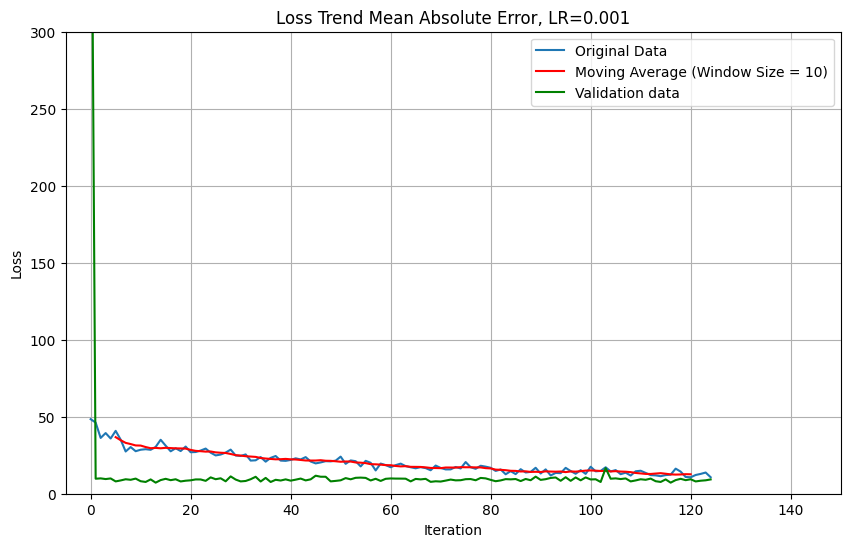

In [100]:
losses = []
validation = []
with open ("output_training_MAElosses_test_0.001LR.txt", 'r') as f:
    for line in f: 
        losses.append(float(line.split()[-1]))
        

with open("output_val_MAElosses_0.001LR.txt", "r") as f2:
    for line2 in f2:
        validation.append(float(line2.split()[-1]))
        


window_size = 10
moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

indices = np.arange(window_size//2, len(losses) - window_size//2 + 1)

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Original Data')
plt.plot(indices, moving_avg, color='red', label=f'Moving Average (Window Size = {window_size})')
plt.plot(validation[0:125], label= "Validation data", color="g")
plt.axis([-5, 150, 0, 300])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Trend Mean Absolute Error, LR=0.001')
plt.legend()
plt.grid(True)
plt.show()